In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from synthpop.models import AxtellModel
from synthpop.infer import Infer, SMCABC
from synthpop.generative import SampleGenerator
import pygtc

/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 . Define model and loss function

In [3]:
model = AxtellModel(N=1000, v=1)

def loss(x):
    ts, ass, _, efforts = x
    init_mean_efforts = efforts[0].mean()
    previous_efforts = efforts[0].copy()
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        previous_efforts = model.reconstruct_effort(previous_efforts, agent, efforts[i+1])
    #return (previous_efforts.mean() - init_mean_efforts).reshape(1,1) + 1
    return (previous_efforts.mean() - init_mean_efforts) + 1

class MetaGenerator(SampleGenerator):
    def forward(self, generator_params):
        E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = generator_params
        def generator(n_agents):
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            phs = np.random.gamma(P_k, P_t, size=n_agents)
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator

# 2. SMCABC

In [4]:
prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
                                    torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])), reinterpreted_batch_ndims=1)
meta_generator = MetaGenerator()
infer = Infer(model=model, meta_generator=meta_generator, prior=prior, loss=loss)
infer_method = SMCABC(num_particles = 100, num_initial_pop=10_000, num_simulations=20_000, epsilon_decay=0.6)
trained_meta_generator = infer.fit(infer_method, num_workers=-1)

Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [00:34<00:00, 292.50it/s]
/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/sbi/inference/abc/smcabc.py:569: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1702.)
  torch.cholesky(kernel_variance_scale * population_cov)
Running 72 simulations in 72 batches.: 100%|██████████| 72/72 [00:00<00:00, 120.63it/s]


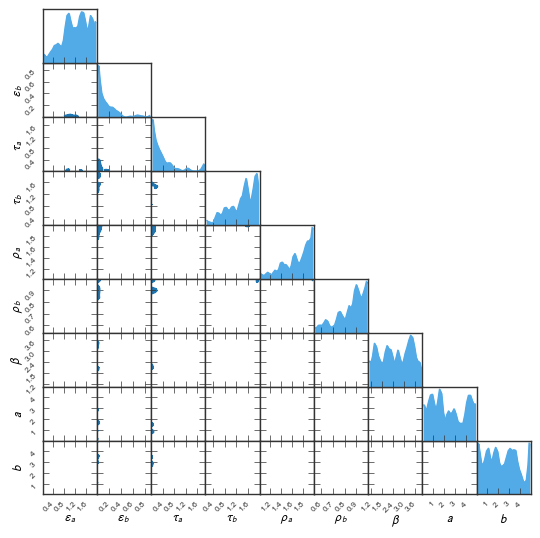

In [5]:
samples = trained_meta_generator.samples.numpy()
pygtc.plotGTC([samples], 
              nContourLevels=1, 
              paramNames=[r"$\epsilon_a$", r"$\epsilon_b$",
                        r"$\tau_a$", r"$\tau_b$",
                        r"$\rho_a$", r"$\rho_b$",
                        r"$\beta$", r"$a$", r"$b$"]);

In [6]:
# get predicted efforts.
def get_mean_efforts(ts, ass, a_efforts):
    mean_efforts = [a_efforts[0].mean()]
    last_efforts = a_efforts[0]
    for i in range(len(ts) - 1):
        agent = ass[i+1]
        new_efforts = model.reconstruct_effort(last_efforts, agent, a_efforts[i+1])
        mean_efforts.append(new_efforts.mean())
        last_efforts = new_efforts
    return mean_efforts

def get_pred_efforts_from_generator(generator, n = 25):
    pred_efforts = []
    times = []
    for j in range(n):
        ts, ass, _, a_efforts = model(generator)
        mean_efforts= get_mean_efforts(ts, ass, a_efforts)
        pred_efforts.append(mean_efforts)
        times.append(ts)
    return times, pred_efforts

prior_times, prior_pred_efforts = get_pred_efforts_from_generator(meta_generator(prior.sample()))
post_times, post_pred_efforts = get_pred_efforts_from_generator(trained_meta_generator())

Text(0.5, 0, 'Time')

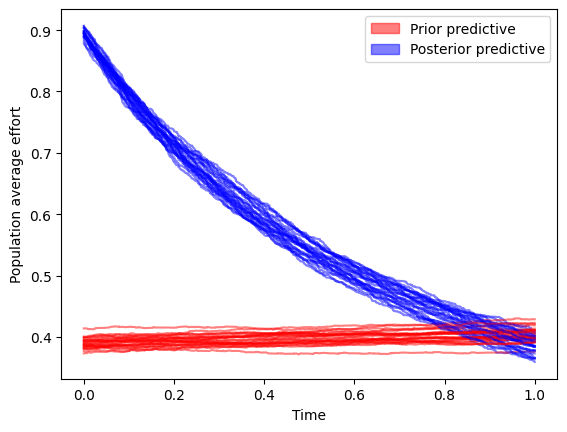

In [7]:
fig, ax = plt.subplots(1,1)
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=0.5, c='b')
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=0.5, c='r')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Prior predictive')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Posterior predictive')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel("Population average effort")
plt.xlabel("Time")

# 3. Variational Inference

In [8]:
from synthpop.generative import MaskedAutoRegressiveFlow
from synthpop.infer import VI

class MetaGenerator(MaskedAutoRegressiveFlow):
    param_min = torch.tensor([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1., 1e-3, 1e-3])
    param_max = torch.tensor([2., 2, 2, 2, 2, 1, 4, 5, 5])
    def forward(self, generator_params=None):
        if generator_params is None:
            generator_params = self.sample(1)[0][0]
        def generator(n_agents):
            params = 10 ** generator_params
            # clamp parameters to adequate range
            params = torch.maximum(self.param_min, params)
            params = torch.minimum(self.param_max, params)
            E_a, E_b, T_a, T_b, P_k, P_t, beta, a, b = params
            # Draw effort levels
            es  = np.random.beta(E_a, E_b, size=n_agents)
            # Draw preferences
            ths = np.random.beta(T_a, T_b, size=n_agents)
            # Draw rates
            phs = np.random.gamma(P_k, P_t, size=n_agents) 
            return es, ths, phs, beta.item(), a.item(), b.item()
        return generator

In [27]:
meta_generator = MetaGenerator(n_parameters = 9, n_hidden_units = 32, n_transforms = 4)
# make aux prior so that regularisation loss is the entropy.
inff = 1000
prior_vi = torch.distributions.Independent(torch.distributions.Uniform(-inff * torch.ones(9), inff * torch.ones(9)), 1)
infer = Infer(model=model, meta_generator=meta_generator, prior=prior_vi, loss=loss)
optimizer = torch.optim.AdamW(meta_generator.parameters(), lr=2e-3)
infer_method = VI(w=1e-2, n_samples_per_epoch=10, optimizer=optimizer, 
                    progress_bar=True, progress_info=True, gradient_estimation_method="score", log_tensorboard=True, n_samples_regularisation=10000)
trained_meta_generator = infer.fit(infer_method, n_epochs=1000, max_epochs_without_improvement=50)

 25%|██▍       | 247/1000 [03:00<09:09,  1.37it/s, loss=0.26, reg=0.60, total=0.86, best loss=0.84, epochs since improv.=50]


In [28]:
with torch.no_grad():
    prior_times, prior_pred_efforts = get_pred_efforts_from_generator(meta_generator(prior.sample()))
    post_times, post_pred_efforts = get_pred_efforts_from_generator(trained_meta_generator())

Text(0.5, 0, 'Time')

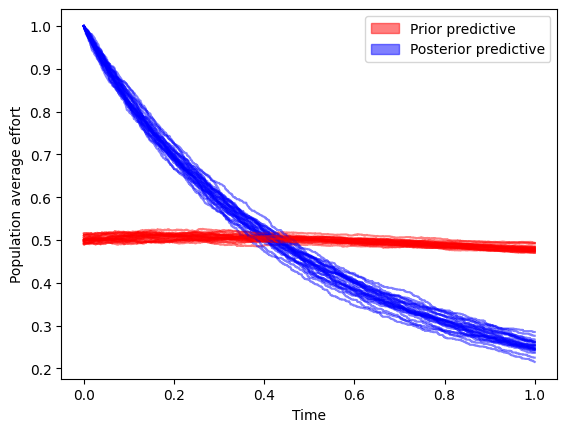

In [29]:
fig, ax = plt.subplots(1,1)
for i in range(len(post_pred_efforts)):
    ax.plot(post_times[i], post_pred_efforts[i], alpha=0.5, c='b')
    ax.plot(prior_times[i], prior_pred_efforts[i], alpha=0.5, c='r')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Prior predictive')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='Posterior predictive')
plt.legend(handles=[red_patch, blue_patch])
plt.ylabel("Population average effort")
plt.xlabel("Time")